In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import laplace
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from batchbald_redux import repeated_mnist, active_learning, batchbald
from main.models import BayesianConvNet, ConvNet
from main.utils import save_experiment, load_experiment
from laplace.curvature import BackPackGGN


%reload_ext autoreload
%autoreload 2

## Data and experiment parameters

In [11]:
# loading data
train_dataset, test_dataset = repeated_mnist.create_MNIST_dataset()

# number of initial samples 
num_initial_samples = 40
num_classes = 10

# get indices of initial samples
initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)

# Experiment parameters

## Active learning parameters
max_training_samples = 100  # Maximum number of samples to acquire from the pool dataset 
acquisition_batch_size = 5  # Number of samples to acquire in each acquisition step

## Training parameters
test_batch_size = 512  # Batch size for testing
batch_size = 64  # Batch size for training
scoring_batch_size = 64  # Batch size for scoring 
training_iterations_nn = 4096 * 6  # Number of training iterations (batches) to run
training_iterations_la = 2024  # Number of training iterations (batches) to run

## Model parameters
hessian_structure = "kron"  # Options: "full", "kron", "lowrank" and "diag"
subset_of_weights = "last_layer"  # Options: "all", "subnetwork" and "last_layer"

kwargs = {"num_workers": 1, "pin_memory": True}

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

print(f"use_cuda: {use_cuda}")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(55000)

train_loader_nn = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations_nn),
    batch_size=batch_size,
    **kwargs,
)

train_loader_la = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations_nn),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

use_cuda: False


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\torch\utils\data\sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


## Running Experiment

In [23]:
# Run experiment
test_accs = []
test_loss = []
added_indices = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")
loss_fn = nn.NLLLoss()

while True:
    model = ConvNet().to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader_nn, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = F.log_softmax(model(data).squeeze(1), dim=1)
        loss = loss_fn(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = model(data).squeeze(1)
            loss += loss_fn(prediction, target)

            prediction = prediction.argmax(dim=1)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire new batch from pool samples using entropy acquisition function
    N = len(active_learning_data.pool_dataset)
    
    la = laplace.Laplace(
                        model,
                        likelihood="classification",
                        subset_of_weights=subset_of_weights,
                        hessian_structure=hessian_structure,
                        backend=BackPackGGN
                     )
    
    print('Fitting Laplace')
    la.fit(train_loader_la, progress_bar=True)

    print('Optimizing prior precision')
    la.optimize_prior_precision(method='marglik', verbose=True)

    determinants = torch.zeros(N, 1)
    for i, (data, _) in tqdm(enumerate(pool_loader) ,desc="Computing LA approximated variances", leave=False): 
        data = data.to(device=device)

        # Obtaining posterior covariance matrixes
        f_samples = la.predictive_samples(data, n_samples=10000)
        covs = torch.stack([torch.cov(f_samples[:, n, :].T)[:-1, :-1] for n in range(f_samples.shape[1])])
        
        # compute log determinant of each element of f_var
        determinants[i*scoring_batch_size:(i+1)*scoring_batch_size] = torch.tensor([(torch.det(covs[i])) for i in range(len(covs))]).unsqueeze(-1)

    # Compute top k log determinant of each element of f_var
    values, indices = torch.topk(determinants, acquisition_batch_size, largest=True, sorted=False, dim=0)
    candidate_batch = batchbald.CandidateBatch(indices=indices.squeeze().tolist(), scores=values.squeeze().tolist())

    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    pbar.update(len(dataset_indices))

Training Set Size:  40%|████      | 40/100 [05:10<?, ?it/s]


Test set: Average loss: -0.0249, Accuracy: 7035/10000 (70.35%)
4960
Fitting Laplace
Optimizing prior precision


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\laplace\baselaplace.py:409: UserWarning: By default `link_approx` is `probit`. Make sure to set it equals to the way you want to call `la(test_data, pred_type=..., link_approx=...)`.
  warnings.warn(


Optimized prior precision is tensor([49.1030]).


Dataset indices:  [35535 17543  7739 40587  2713]
Scores:  [9.047657188303036e-35, 1.76973422406532e-36, 9.807657011139302e-37, 4.3138675027926285e-37, 4.956574276597854e-38]
Labels:  tensor([5, 5, 5, 5, 5])


Test set: Average loss: -0.0201, Accuracy: 7024/10000 (70.24%)
4955
Fitting Laplace


KeyboardInterrupt: 

In [22]:
indices.tolist()

[[2547], [4422], [2994], [1513], [3677]]

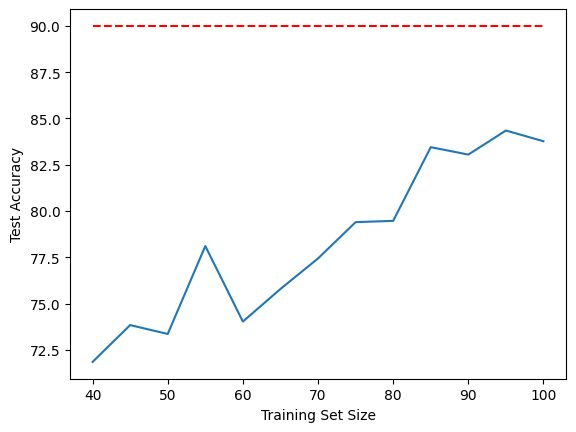

In [ ]:
plt.plot(np.arange(start=num_initial_samples, stop=max_training_samples + acquisition_batch_size, step=acquisition_batch_size), test_accs)
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.hlines(90, num_initial_samples, max_training_samples, colors='r', linestyles='dashed')

plt.show()

## Storing results

In [ ]:
save = False

if save:
    params_dict = {
        'num_initial_samples': num_initial_samples,
        'num_classes': num_classes,
        'max_training_samples': max_training_samples,
        'acquisition_batch_size': acquisition_batch_size,
        'test_batch_size': test_batch_size,
        'batch_size': batch_size,
        'scoring_batch_size': scoring_batch_size,
        'training_iterations_nn': training_iterations_nn,
        'training_iterations_la': training_iterations_la,
    }

    save_experiment('full_last_layer_probit', params_dict, {
        'test_accs': test_accs,
        'test_loss': test_loss,
        'added_indices': added_indices
    })